In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [3]:
# Load the dataset and split it into training and testing sets
df = pd.read_csv('Model_N_train_test.csv',index_col=0)
X = df.iloc[:, 1:]  # Use all columns except the first one as features
y = df.iloc[:, 0]   # Use the first column as the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=89)

In [4]:
# Create and fit Random Forest Regressor model
model = RandomForestRegressor(n_estimators=1000, max_depth = 30,random_state=2)

model.fit(X_train, y_train)

y_pred_train_rf = model.predict(X_train)
y_pred_test_rf = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
rmse_tr_rf = mean_squared_error(y_train, y_pred_train_rf, squared=False)
rmse_te_rf = mean_squared_error(y_test, y_pred_test_rf, squared=False)

# Calculate R² (Coefficient of Determination)
r2_train = r2_score(y_train, y_pred_train_rf)
r2_test = r2_score(y_test, y_pred_test_rf)

print('RMSE(training)=%.3f' % rmse_tr_rf)
print('RMSE(test)=%.3f' % rmse_te_rf)
print('R2(training)=%.3f' % r2_train)
print('R2(test)=%.3f' % r2_test)

RMSE(training)=0.019
RMSE(test)=0.030
R2(training)=0.989
R2(test)=0.972


/opt/anaconda3/envs/shap/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/shap/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


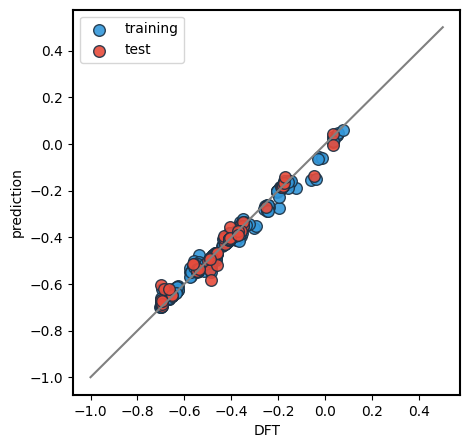

In [5]:
# Visualize the correlation between true values (DFT) and predictions for both training and testing sets
plt.style.use('default')
x_y_x = np.arange(-1, 0.6, 0.1)
x_y_y = np.arange(-1, 0.6, 0.1)
plt.figure(figsize=(5,5))
plt.scatter(y_train, y_pred_train_rf, s=70, alpha = 0.9,color='#3498DB',label ='training',edgecolor='#1C3144')
plt.scatter(y_test,y_pred_test_rf,s=70,alpha = 0.9,color ='#E74C3C',label ='test',edgecolor='#1C3144')
plt.plot(x_y_x, x_y_y, color='gray')
plt.legend()
plt.xlabel('DFT')
plt.ylabel('prediction')
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.show()

ads-bandcenter: 0.5397986243594726
Lpa: 0.17718188400104226
Lau-H: 0.09887252377026184
CAZ-M: 0.06110735589026387
CAY: 0.04969299302563046
Cads-val: 0.03987822004756061
CAX: 0.028569446222834534
Pstr: 0.004898952682933784
Nval: 0.0
EI: 0.0
EA: 0.0
Enads: 0.0
CN: 0.0


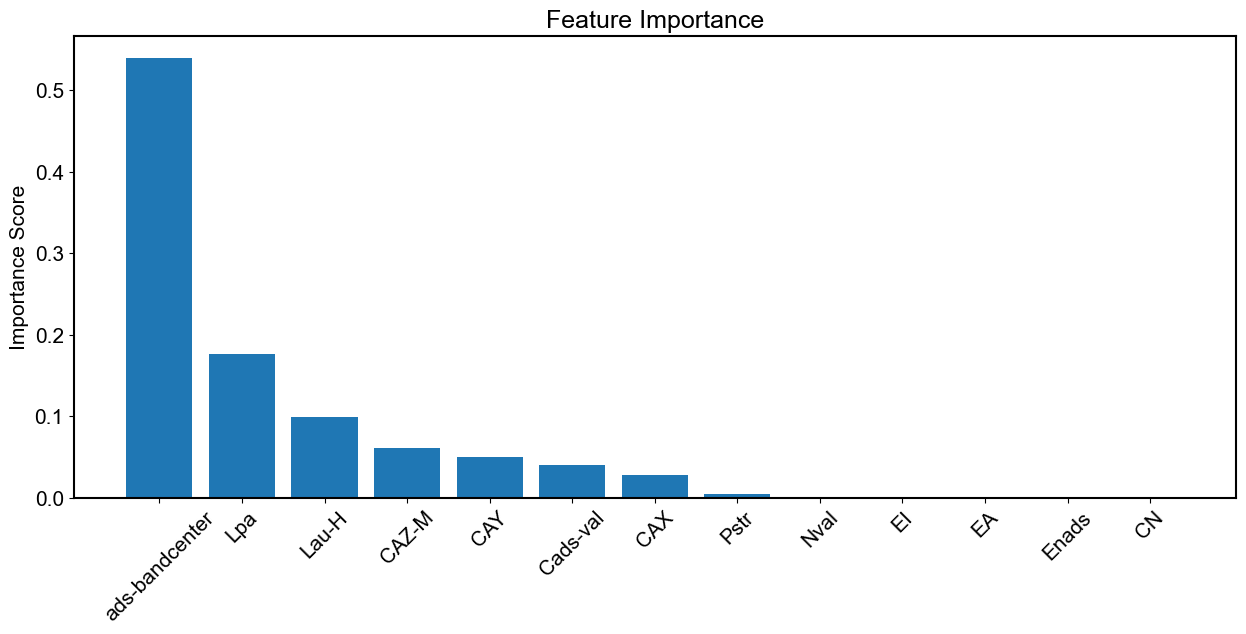

In [6]:
# Extract and visualize the feature importance scores from the trained model
importance_scores = model.feature_importances_
feature_importances = dict(zip(X_train.columns, importance_scores))
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

features = [feature[0] for feature in sorted_features]
importances = [feature[1] for feature in sorted_features]
plt.style.use('default') 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 15
plt.figure(figsize=(15, 6))
plt.bar(features, importances)
plt.xticks(rotation=45)
plt.ylabel('Importance Score')
plt.title('Feature Importance')
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.show()

In [7]:
# Perform cross-validation using KFold
from sklearn.model_selection import cross_val_score, KFold
crossvalidation = KFold(n_splits = 10,shuffle = True)
r2_score_lr = cross_val_score(model, X, y,scoring = 'r2',cv=crossvalidation)
rmse_score_lr = cross_val_score(model,X,y,scoring ='neg_root_mean_squared_error',
                               cv = crossvalidation)
print('Cross_validation_results:')
print('Folds: %i, mean R2: %.3f' %(len(r2_score_lr),r2_score_lr.mean()))
print('Folds: %i, mean RMSE: %.3f' %(len(rmse_score_lr),-rmse_score_lr.mean()))

Cross_validation_results:
Folds: 10, mean R2: 0.921
Folds: 10, mean RMSE: 0.048


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
 98%|===================| 665/680 [00:32<00:00]        

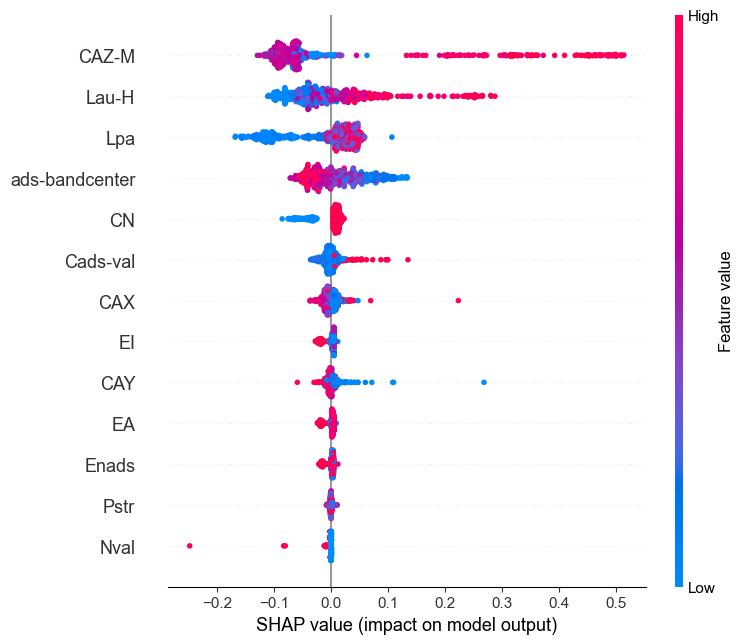

In [7]:
# SHAP analysis
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train) 

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train)
plt.show()

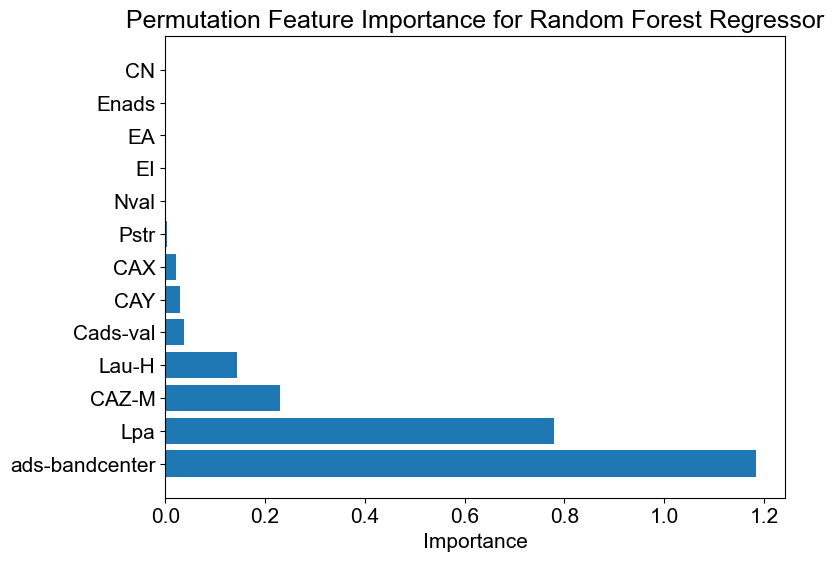

In [8]:
# Permutation feature importance analysis
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 15
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#1f77b4')
plt.xlabel('Importance')
plt.title('Permutation Feature Importance for Random Forest Regressor')
plt.show()